In [1]:
import glacierml as gl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pth = '/data/fast1/glacierml/data/'
pd.set_option('display.max_columns', None)
import configparser
import cartopy.crs as crs
import cartopy.feature as cfeature

In [2]:
RGI = gl.load_RGI()

In [3]:
parameterization = '5'
config = configparser.ConfigParser()
config.read('model_parameterization.txt')

data = gl.load_training_data(
    pth = '/data/fast1/glacierml/data/',
    area_scrubber = config[parameterization]['area scrubber'],
    anomaly_input = float(   config[parameterization]['size threshold']   )
)
data = data.drop(
    data[data['distance test'] >= float(config[parameterization]['distance threshold']  
                                            )].index
)

data = data.drop([
#     'RGIId','region', 'RGI Centroid Distance', 
#     'AVG Radius', 
#     'Roundness', 
#     'distance test', 
#     'size difference'
], axis = 1)
data
# data = gl.parameterize_data(parameterization)

,RGIId,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax,Thickness,region,RGI Centroid Distance,size difference,AVG Radius,Roundness,distance test
0,RGI60-01.00037,63.469173,-146.528168,12.0,722,1841,3081,234.583,30,41911,235.0,01,1851.480653,0.046411,8641.185569,0.206179,0.214262
1,RGI60-01.00570,63.281000,-145.427000,14.0,1162,1858,2438,17.567,172,8639,147.0,01,707.576070,0.090735,2364.688092,0.273722,0.299226
2,RGI60-01.01104,58.380000,-134.349000,10.0,676,1123,1494,9.528,327,6332,66.0,01,643.556206,0.185641,1741.509861,0.275033,0.369539
8,RGI60-01.16374,61.200000,-140.302000,14.0,2145,2509,2894,5.859,341,3374,66.0,01,0.000000,0.362558,1365.641836,0.404755,0.000000
9,RGI60-02.03411,51.177000,-116.330000,15.3,2390,2526,2853,0.872,69,1181,70.0,02,0.000000,0.128000,526.845538,0.446101,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,RGI60-17.14088,-33.029600,-70.098400,29.0,2929,5121,5894,8.376,358,8560,59.0,17,155.918952,0.065649,1632.839125,0.190752,0.095489
490,RGI60-17.14647,-30.145400,-69.927600,29.3,4664,5187,5525,1.189,148,1596,28.0,17,58.748637,0.380729,615.199524,0.385463,0.095495
491,RGI60-17.15038,-28.538700,-69.731800,16.0,4784,5234,5597,3.140,190,3349,39.0,17,110.221209,0.324895,999.746489,0.298521,0.110249
492,RGI60-17.15087,-28.381400,-69.609100,11.6,5068,5406,5753,5.209,79,3782,67.0,17,67.213847,0.217056,1287.663076,0.340471,0.052198


In [4]:
def analyze(df = data, verbose = False):

    # df1['Area'] = np.log(df1['Area'])
    # dataset['Lmax'] = dataset['Lmax'] * 1e3
    # dataset['Lmax'] = np.log(dataset['Lmax'])
    df.name = 'df'
#     print(df)

    # lr_input = 0.01
    rs = 0
    # ep_input = 2000
    layer_1_input = 20
    layer_2_input = 15
    dropout = True

    dnn_model = gl.build_and_train_model(
                            df, 
    #                         learning_rate = float(lr_input), 
    #                         random_state = rs, 
    #                         epochs = int(ep_input), 
                            parameterization = parameterization, 
#                             res = res,
                            layer_1 = layer_1_input,
                            layer_2 = layer_2_input,
                            dropout = dropout,
                            writeToFile = False,
                            loss = 'mean_absolute_error'
    )   

    model_thicknesses = gl.evaluate_model(
        str(layer_1_input) + '-' + str(layer_2_input), rs, df,
        dnn_model, parameterization = parameterization
    )
    model_thicknesses
    
    if verbose:
    
        plt.scatter(
            model_thicknesses['E&L Thickness'],
            model_thicknesses['GlaThiDa Thickness'],
            marker = '.')
        plt.xlabel('E&L Thickness')
        plt.ylabel('GlaThiDa Thickness')
        plt.plot(
            [model_thicknesses['GlaThiDa Thickness'].min(),
            model_thicknesses['GlaThiDa Thickness'].max()],
            [model_thicknesses['GlaThiDa Thickness'].min(),
            model_thicknesses['GlaThiDa Thickness'].max()],

            c = 'red'
        )
        os = list(df)
        os = [ele for ele in os if ele != 'Thickness']

        plt.title(", ".join(os))
        plt.show()
    return model_thicknesses

# With ALL data

In [5]:
df1 = data[['CenLat', 'CenLon', 'Zmin', 
               'Zmed',
               'Zmax',
               'Aspect',
               'Lmax',
               'Slope', 'Area', 'Thickness']]
model_thicknesses1 = analyze(df1)

# No geographic location

In [6]:
df2 = data[['Zmin', 
               'Zmed', 
               'Zmax',
               'Aspect',
               'Lmax',
               'Slope', 'Area', 'Thickness']]
model_thicknesses2 = analyze(df2)

# No geographic or elevation data

In [7]:
df3 = data[[
    'Lmax',
    'Slope', 'Area', 'Thickness']]
model_thicknesses3 = analyze(df3)

# Include Roundness

In [8]:
df4 = pd.concat([df1, data['Roundness']], axis =1 )
model_thicknesses4 = analyze(df4)

In [9]:
df5 = pd.concat([df2, data['Roundness']], axis =1 )
model_thicknesses5 = analyze(df5)

In [10]:
df6 = pd.concat([df3, data['Roundness']], axis =1 )
model_thicknesses6 = analyze(df6)

# Look at it all at once

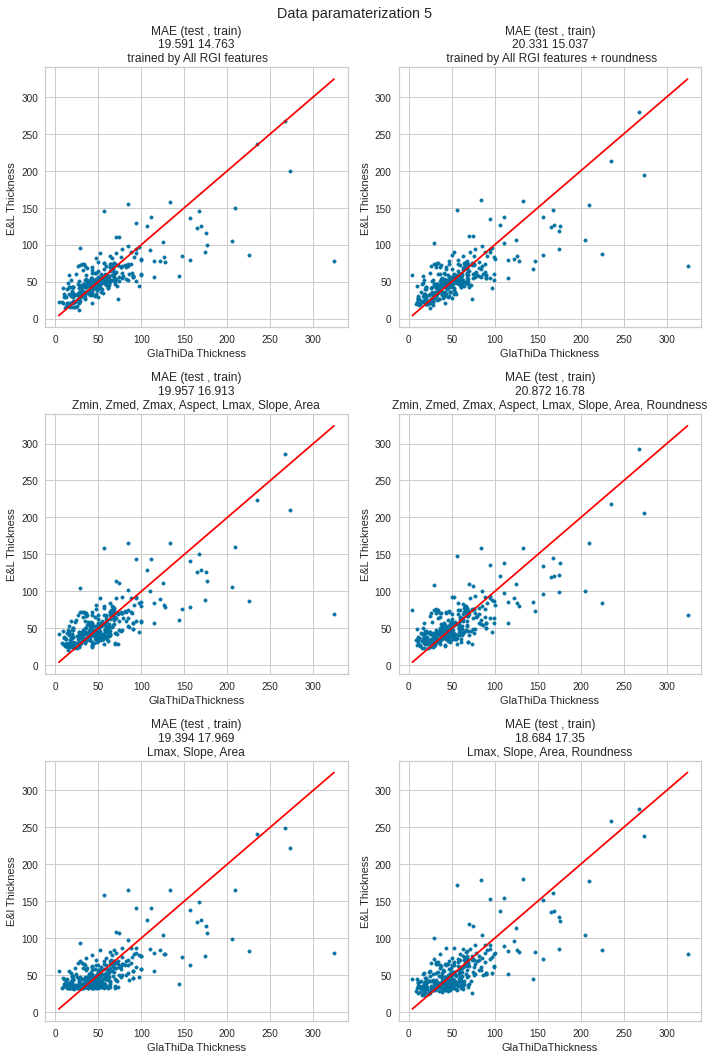

In [11]:
fig, axs = plt.subplots(3, 2, figsize = (10,15))
# for n in range(0)
axs[0, 0].scatter(
    model_thicknesses1['GlaThiDa Thickness'],
    model_thicknesses1['E&L Thickness'],
    marker = '.'
)
axs[0, 0].plot(
    [model_thicknesses1['GlaThiDa Thickness'].min(),
    model_thicknesses1['GlaThiDa Thickness'].max()],
    [model_thicknesses1['GlaThiDa Thickness'].min(),
    model_thicknesses1['GlaThiDa Thickness'].max()],

    c = 'red'
)
os = list(df1)
os = [ele for ele in df1 if ele != 'Thickness']
axs[0, 0].set_title(
    'MAE (test , train)\n'+
    str(np.round(model_thicknesses1['test mae'].loc[0], 3))+ ' ' +
    str(
        np.round(model_thicknesses1['train mae'].loc[0], 3)
    ) + 
    '\n trained by All RGI features'
                   )
axs[0, 0].set_xlabel('GlaThiDa Thickness')
axs[0, 0].set_ylabel('E&L Thickness')


axs[0, 1].scatter(
    model_thicknesses4['GlaThiDa Thickness'],
    model_thicknesses4['E&L Thickness'],
    marker = '.'
)
axs[0, 1].plot(
    [model_thicknesses4['GlaThiDa Thickness'].min(),
    model_thicknesses4['GlaThiDa Thickness'].max()],
    [model_thicknesses4['GlaThiDa Thickness'].min(),
    model_thicknesses4['GlaThiDa Thickness'].max()],

    c = 'red'
)
os = list(df4)
os = [ele for ele in df4 if ele != 'Thickness']

axs[0,1].set_title(
        'MAE (test , train)\n'+

    str(np.round(model_thicknesses4['test mae'].loc[0], 3))+ ' ' +
    str(np.round(model_thicknesses4['train mae'].loc[0], 3)) + 
   '\n trained by All RGI features + roundness')

axs[0, 1].set_xlabel('GlaThiDa Thickness')
axs[0, 1].set_ylabel('E&L Thickness')

axs[1, 0].scatter(
    model_thicknesses2['GlaThiDa Thickness'],
    model_thicknesses2['E&L Thickness'],
    marker = '.'
)
axs[1, 0].plot(
    [model_thicknesses2['GlaThiDa Thickness'].min(),
    model_thicknesses2['GlaThiDa Thickness'].max()],
    [model_thicknesses2['GlaThiDa Thickness'].min(),
    model_thicknesses2['GlaThiDa Thickness'].max()],

    c = 'red'
)
os = list(df2)
os = [ele for ele in df2 if ele != 'Thickness']

# plt.title(", ".join(os))
axs[1, 0].set_title(
        'MAE (test , train)\n'+
        str(np.round(model_thicknesses2['test mae'].loc[0], 3))+ ' ' +
        str(np.round(model_thicknesses2['train mae'].loc[0], 3)) + '\n'+", ".join(os))


axs[1, 0].set_xlabel('GlaThiDaThickness')
axs[1, 0].set_ylabel('E&L Thickness')



axs[1, 1].scatter(
    model_thicknesses5['GlaThiDa Thickness'],
    model_thicknesses5['E&L Thickness'],
    marker = '.'
)
axs[1, 1].plot(
    [model_thicknesses5['GlaThiDa Thickness'].min(),
    model_thicknesses5['GlaThiDa Thickness'].max()],
    [model_thicknesses5['GlaThiDa Thickness'].min(),
    model_thicknesses5['GlaThiDa Thickness'].max()],

    c = 'red'
)
os = list(df5)
os = [ele for ele in df5 if ele != 'Thickness']

# plt.title(", ".join(os))
axs[1, 1].set_title(
        'MAE (test , train)\n'+
        str(np.round(model_thicknesses5['test mae'].loc[0], 3))+ ' ' +
        str(np.round(model_thicknesses5['train mae'].loc[0], 3)) + '\n'+", ".join(os))
axs[1, 1].set_xlabel('GlaThiDa Thickness')
axs[1, 1].set_ylabel('E&L Thickness')



axs[2, 0].scatter(
    model_thicknesses3['GlaThiDa Thickness'],
    model_thicknesses3['E&L Thickness'],
    marker = '.'
)
axs[2, 0].plot(
    [model_thicknesses3['GlaThiDa Thickness'].min(),
    model_thicknesses3['GlaThiDa Thickness'].max()],
    [model_thicknesses3['GlaThiDa Thickness'].min(),
    model_thicknesses3['GlaThiDa Thickness'].max()],

    c = 'red'
)
os = list(df3)
os = [ele for ele in df3 if ele != 'Thickness']

# plt.title(", ".join(os))
axs[2, 0].set_title(
        'MAE (test , train)\n'+
        str(np.round(model_thicknesses3['test mae'].loc[0], 3))+ ' ' +
        str(np.round(model_thicknesses3['train mae'].loc[0], 3)) + '\n'+", ".join(os))

axs[2, 0].set_xlabel('GlaThiDa Thickness')
axs[2, 0].set_ylabel('E&l Thickness')



axs[2, 1].scatter(
    model_thicknesses6['GlaThiDa Thickness'],
    model_thicknesses6['E&L Thickness'],
    marker = '.'
)
axs[2, 1].plot(
    [model_thicknesses6['GlaThiDa Thickness'].min(),
    model_thicknesses6['GlaThiDa Thickness'].max()],
    [model_thicknesses6['GlaThiDa Thickness'].min(),
    model_thicknesses6['GlaThiDa Thickness'].max()],

    c = 'red'
)
os = list(df6)
os = [ele for ele in df6 if ele != 'Thickness']


# plt.title(", ".join(os))
axs[2, 1].set_title(
        'MAE (test , train)\n'+
        str(np.round(model_thicknesses6['test mae'].loc[0], 3))+ ' ' +
        str(np.round(model_thicknesses6['train mae'].loc[0], 3))+ '\n'+", ".join(os))


axs[2, 1].set_xlabel('GlaThiDaThickness')
axs[2, 1].set_ylabel('E&L Thickness')
plt.suptitle('Data paramaterization ' + parameterization)

plt.tight_layout()

In [12]:
dft = model_thicknesses4.sort_values('Residual', ascending = False)

In [13]:
dft[dft['Residual'] == dft['Residual'].max()]

,CenLat,CenLon,Zmin,Zmed,Zmax,Aspect,Lmax,Slope,Area,Roundness,model,test mae,train mae,layer architecture,parameterization,total parameters,GlaThiDa Thickness,E&L Thickness,Residual
339,-38.983,-71.5317,1833,2098,2265,232,3177,5.9,5.273,0.40779,0,20.331005,15.037072,20-15,5,572,324.0,71.394707,252.605293


In [14]:
dft[dft['Residual'] == dft['Residual'].min()]

,CenLat,CenLon,Zmin,Zmed,Zmax,Aspect,Lmax,Slope,Area,Roundness,model,test mae,train mae,layer architecture,parameterization,total parameters,GlaThiDa Thickness,E&L Thickness,Residual
171,78.7872,13.1481,73,581,1015,285,24201,7.4,108.297,0.242605,0,20.331005,15.037072,20-15,5,572,56.0,147.496216,-91.496216


In [15]:
dft['Lmax'][(dft['Residual'] >= -5) & (dft['Residual'] <=0)].median()

2628.5

In [16]:
sum(dft['Residual'])

449.0603504180908

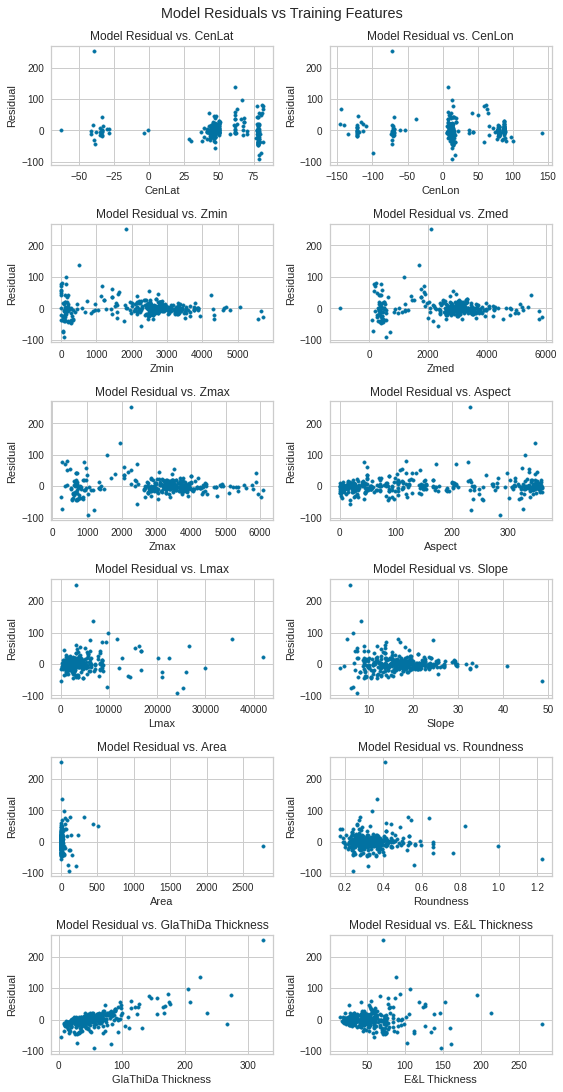

In [17]:
fig = plt.subplots(6,2, figsize = (8,15))

for n, i in enumerate([
    'CenLat', 'CenLon','Zmin','Zmed','Zmax',
          'Aspect',
    'Lmax','Slope','Area','Roundness', 'GlaThiDa Thickness','E&L Thickness']):
#     print(i)
    ax = plt.subplot(6,2,n+1)
    ax.scatter(
        
        (dft[i]),
        (dft['Residual']),
        marker = '.'
    )
    ax.set_ylabel('Residual')
    ax.set_xlabel(i)
#     ax.set_yscale('log')
#     ax.set_xscale('log')
    ax.set_title('Model Residual vs. '+ i )
plt.tight_layout()
plt.suptitle('Model Residuals vs Training Features', y = 1.01)
plt.show()
    